lattice spacing
0.009523809523809525
Running...


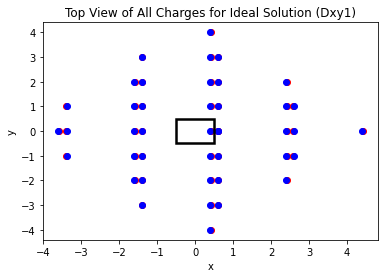

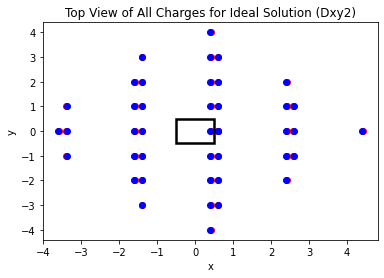

Still running...


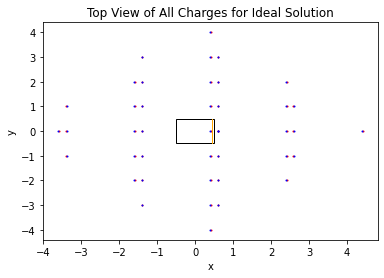

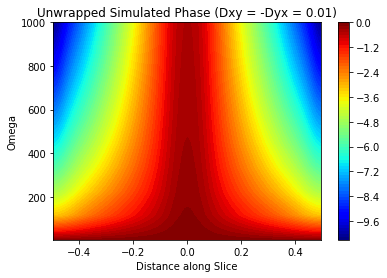

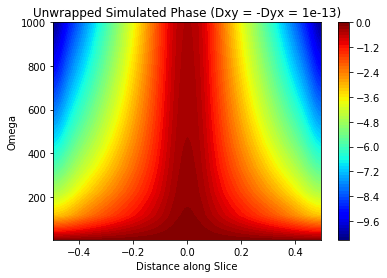

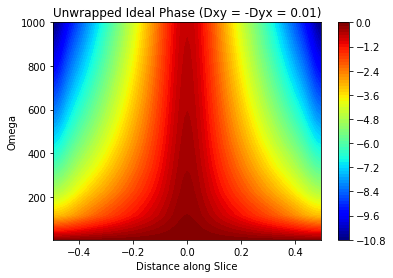

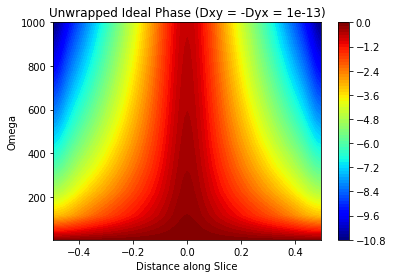

Simulated Dxy1 - Simulated Dxy2 (Sim Signal)


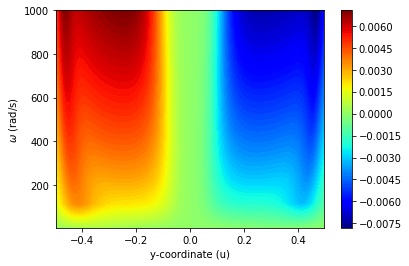

Ideal Dxy1 - Ideal Dxy2 (Ideal Signal)


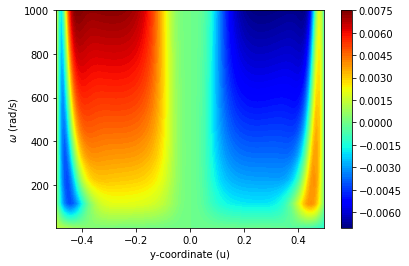

Error


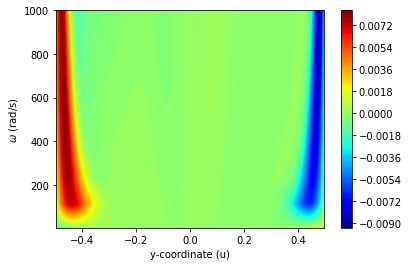

Error with cutoff


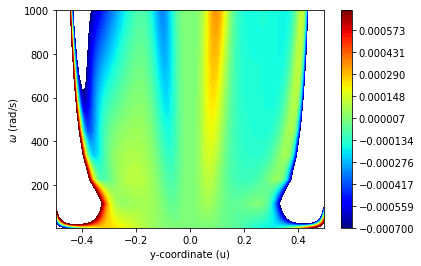

In [1]:


from dolfin import *
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib
import matplotlib.patches as patch
from mpl_toolkits.mplot3d import Axes3D
from skimage import data, img_as_float, color, exposure
from skimage.restoration import unwrap_phase
from scipy.optimize import curve_fit
import pylab as plt
import cmath


def solver(g, xmax, ymax, zmax, tol, mesh, omega, alpha, Dxy, Dxx, Dyy):
    (ureal, uimag) = TrialFunctions(W)
    (v1, v2) = TestFunctions(W)
    a = (alpha*dot(grad(uimag),grad(v1)) + omega*ureal*v1 + omega*uimag*v2 - alpha*dot(grad(ureal),grad(v2)))*dx + (Dxy/np.sqrt(Dxx*Dyy)*alpha*uimag.dx(1)*v1.dx(0) - Dxy/np.sqrt(Dxx*Dyy)*alpha*uimag.dx(0)*v1.dx(1) - Dxy/np.sqrt(Dxx*Dyy)*alpha*ureal.dx(1)*v2.dx(0) + Dxy/np.sqrt(Dxx*Dyy)*alpha*ureal.dx(0)*v2.dx(1))*dx
    L =  - g*v2*dx
    def bot(x, on_boundary): return on_boundary and near(x[2], -zmax/2, tol)
    noslip = Constant(0.0)
    bc0 = DirichletBC(W.sub(0), noslip, bot)
    bc1 = DirichletBC(W.sub(1), noslip, bot)
    G = Expression('0', degree = 0)
    def boundary(x, on_boundary):
            return on_boundary and not near(x[2], -zmax/2, tol)    
    bcs = [bc0, bc1]
    w = Function(W)
    solve(a == L, w, bcs, solver_parameters={'linear_solver':'mumps'})
    (ureal, uimag) = w.split()
    return ureal, uimag

def phasef(ureal, uimag, xline, yline, depth, z):
    zpoints = len(z)
    wtot = 0
    upointr = 0
    upointi = 0
    for i in range(0,zpoints):
        uliner = ureal(xline,yline,z[i])
        ulinei = uimag(xline,yline,z[i])
        wlayer = np.exp(z[i]/depth)#/ np.sum()
        wtot = wtot + wlayer
        upointr = upointr + uliner*wlayer
        upointi = upointi + ulinei*wlayer
    upointr = upointr/wtot
    upointi = upointi/wtot
    phase = np.arctan2(upointi, upointr)
    return phase

def linepoints(theta, truexc, trueyc, truex, truey, truez, spacing):
    d = 0.0
    listpoints = np.array([[d, truexc, trueyc]])
    lookright = True 
    while lookright:
        d = d+spacing
        xtemp = truexc + np.cos(theta)*d
        ytemp = trueyc + np.sin(theta)*d
        if xtemp > (truex/2 + 0.00000001) or ytemp > (truey/2 + 0.00000001) or xtemp < (-truex/2 - 0.00000001) or ytemp < (-truey/2 - 0.00000001):
            lookright = False
        else:
            ytemp = min(ytemp, truey/2)
            xtemp = min(xtemp, truex/2)
            ytemp = max(ytemp, -truey/2)
            xtemp = max(xtemp, -truex/2)
            listpoints = np.append(listpoints,[[d, xtemp, ytemp]], axis = 0)
    lookleft = True
    d = 0
    while lookleft:
        d = d - spacing
        xtemp = truexc + np.cos(theta)*d
        ytemp = trueyc + np.sin(theta)*d
        #print(ytemp)
        if xtemp > (truex/2 + 0.00000001) or ytemp > (truey/2 + 0.00000001) or xtemp < (-truex/2 - 0.00000001) or ytemp < (-truey/2 - 0.00000001):
            lookleft = False
        else:
            ytemp = min(ytemp, truey/2)
            xtemp = min(xtemp, truex/2)
            ytemp = max(ytemp, -truey/2)
            xtemp = max(xtemp, -truex/2)
            listpoints = np.append([[d, xtemp, ytemp]],listpoints, axis = 0)
    return listpoints

    
def checkradius(radius, truxc, trueyc, truex, truey, x, y):
    if (radius + truexc) > truex/2 or (radius + trueyc) > truey/2 or (radius - truexc) < -truex/2 or (radius - trueyc) < -truey/2:
            radius = min(np.array([truex/2 - truexc, truey/2 - trueyc]))
            print('Radius changed to fall within boundary')
            print('Radius = ' + str(radius))
    rpoints = np.zeros(2)
    xr = np.array([0])
    yr = np.array([0])
    thetal = np.linspace(0, 2*np.pi, 1000)
    for i in range (0, len(thetal)):
        theta = thetal[i]
        xpoint = radius*np.cos(theta) + truexc
        ypoint = radius*np.sin(theta) + trueyc
        xr = np.append(xr, xpoint)
        yr = np.append(yr, ypoint)
    return radius, xr, yr, thetal

def phaseline(ureal, uimag, xline, yline, depth, z):
    phasearray = np.zeros(len(xline))
    for i in range(0, len(xline)):
        phasearray[i] = phasef(ureal, uimag, xline[i], yline[i], depth, z)
    return phasearray

def Tphaseline(xc, yc, zc, omega, A, xline, yline, depth, z, sign):
    phasearray = np.zeros(len(xline))
    for i in range(0, len(xline)):
        #phasearray[i] = phasef(ureal, uimag, xline[i], yline[i], depth, z)
        phasearray[i] = Tphasef(xc, yc, zc, omega, A, xline[i], yline[i], depth, z, sign)
    return phasearray
    
def phasecirc(ureal, uimag, xr, yr, depth, z):
    phasearray = np.zeros(len(xr)-1)
    for i in range(1, len(xr)):
        phasearray[i-1] = phasef(ureal, uimag, xr[i], yr[i], depth, z)
    return phasearray

def utotal(cutnumx, cutnumy, x, y, z, zpoints, ureal, uimag, depth): 
    wtot = 0
    utotr = np.zeros(cutnumy*cutnumx)
    utoti = np.zeros(cutnumy*cutnumx)
    for i in range(0,zpoints):
        #print(z[i])
        points = [(x_, y_, z[i]) for x_ in x for y_ in y]
        u_sheetr = np.array([ureal(point) for point in points])
        u_sheeti = np.array([uimag(point) for point in points])
        wlayer = np.exp(z[i]/depth)#/ np.sum()
        wtot = wtot + wlayer
        utotr = utotr + u_sheetr * wlayer
        utoti = utoti + u_sheeti * wlayer
    utotr = utotr/wtot
    utoti = utoti/wtot
    utotr = np.reshape(utotr, (cutnumx, cutnumy))
    utoti = np.reshape(utoti, (cutnumx, cutnumy))
    return utotr, utoti

def Temp_at_point(xc, yc, zc, omega, A, x, y, z):
    r = np.sqrt((x - xc)**2 + (y - yc)**2 + (z - zc)**2)
    T = A/r*exp(-np.sqrt(1j*omega)*r)
    Treal = T.real
    Timag = T.imag
    return Treal, Timag

def Ttotal(cutnumx, cutnumy, x, y, z, cutnumz, xc, yx, zc, depth, sign): 
    #changed zpoints to cutnumz
    wtot = 0
    Ttotr = np.zeros([cutnumy,cutnumx])
    Ttoti = np.zeros([cutnumy,cutnumx])
    for i in range(0,cutnumz):
        T_sheetr = np.zeros([cutnumy,cutnumx])
        T_sheeti = np.zeros([cutnumy,cutnumx])
        for j in range(0,len(y)):
            for k in range(0,len(x)):
                for l in range(0,len(xc)):
                    Trnew, Tinew = Temp_at_point(xc[l], yc[l], zc[l], omega, A, x[k], y[j], z[i])
                    T_sheetr[j,k] += sign[l]*Trnew
                    T_sheeti[j,k] += sign[l]*Tinew
        wlayer = np.exp(z[i]/depth)#/ np.sum()
        wtot = wtot + wlayer
        Ttotr = Ttotr + T_sheetr * wlayer
        Ttoti = Ttoti + T_sheeti * wlayer
    Ttotr = Ttotr/wtot
    Ttoti = Ttoti/wtot
    Ttotr = np.transpose(Ttotr)
    Ttoti = np.transpose(Ttoti)
    return Ttotr, Ttoti

def Tphasef(xc, yc, zc, omega, A, xline, yline, depth, z, sign):
    zpoints = len(z)
    wtot = 0
    Ttotr = 0
    Ttoti = 0
    for i in range(0,zpoints):
        Tpointr = 0
        Tpointi = 0
        for l in range(0,len(xc)):
            Trnew, Tinew = Temp_at_point(xc[l], yc[l], zc[l], omega, A, xline, yline, z[i])
            Tpointr = Tpointr + Trnew * sign[l]
            Tpointi = Tpointi + Tinew * sign[l]
        wlayer = np.exp(z[i]/depth)#/ np.sum()
        wtot = wtot + wlayer
        Ttotr = Ttotr + Tpointr*wlayer
        Ttoti = Ttoti + Tpointi*wlayer
    Ttotr = Ttotr/wtot
    Ttoti = Ttoti/wtot
    phase = np.arctan2(Ttoti, Ttotr)
    return phase

def scatter3d(xdata,ydata,zdata, udata, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(udata), vmax=max(udata))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(xdata, ydata, zdata, c=scalarMap.to_rgba(udata))
    scalarMap.set_array(udata)
    fig.colorbar(scalarMap)
    plt.show()
    
def scatter3dphase(meshpts, uarray):
    meshpts = mesh.coordinates()
    xdata = meshpts[:,0]
    xdata = np.transpose(xdata)
    ydata = meshpts[:,1]
    ydata = np.transpose(ydata)
    zdata = meshpts[:,2]
    zdata = np.transpose(zdata)
    cm = plt.get_cmap('jet')
    cNorm = matplotlib.colors.Normalize(vmin=min(uarray), vmax=max(uarray))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(xdata, ydata, zdata, c=scalarMap.to_rgba(uarray))
    scalarMap.set_array(uarray)
    fig.colorbar(scalarMap)
    plt.show()
    
def scatterT(meshpts, T):
    meshpts = mesh.coordinates()
    xdata = meshpts[:,0]
    xdata = np.transpose(xdata)
    ydata = meshpts[:,1]
    ydata = np.transpose(ydata)
    zdata = meshpts[:,2]
    zdata = np.transpose(zdata)
    cm = plt.get_cmap('jet')
    cNorm = matplotlib.colors.Normalize(vmin=min(T), vmax=max(T))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(xdata, ydata, zdata, c=scalarMap.to_rgba(T))
    scalarMap.set_array(T)
    fig.colorbar(scalarMap)
    plt.show()
    
def Temp_all_mesh(xc, yc, zc, omega, A, meshpts, Tr, Ti, sign):
    #Check if need to scale meshpts by D again
    meshpts = mesh.coordinates()
    xs = meshpts[:,0]
    ys = meshpts[:,1]
    zs = meshpts[:,2]
    for i in range (0, len(meshpts)):
        for j in range (0, len(xc)):
            r = np.sqrt((xs[i] - xc[j])**2 + (ys[i] - yc[j])**2 + (zs[i] - zc[j])**2)
            T = A/r*exp(-np.sqrt(1j*omega)*r)
            Treal = T.real
            Timag = T.imag
            Tr[i] = Tr[i] + sign[j]*Treal
            Ti[i] = Ti[i] + sign[j]*Timag
    return Tr, Ti

#Find a column from a list, used to get the x and y data seperately
def column(matrix, i):
    return [row[i] for row in matrix]

#Reflect over a face listed by side to get new coordinates. Same +x, -x, +y, -y indexing as types
def refFace(x0, y0, x_box, y_box, side):
    if(side == 0):
        newPt = [x_box + (x_box - x0), y0]
    if(side == 1):
        newPt = [-x_box + (-x_box - x0), y0]
    if(side == 2):
        newPt = [x0, y_box + (y_box - y0)]
    if(side == 3):
        newPt = [x0, -y_box + (-y_box - y0)]
    return newPt

#Initialize the list of reflected points with reflections from the base source
#over each boundary
def reflectionStart(x0, y0, x_box, y_box, types):
    refPts = []
    faces = [0, 1, 2, 3]
    order = 1
    refPts.append(refFace(x0, y0, x_box, y_box, 0))
    refPts.append(refFace(x0, y0, x_box, y_box, 1))
    refPts.append(refFace(x0, y0, x_box, y_box, 2))
    refPts.append(refFace(x0, y0, x_box, y_box, 3))
    charges = types
    return refPts, faces, order, charges

#Take a list of reflected charge points and which face they were reflected over most recently
#and reflect those points over all the other faces
def newRefs(Pts, x_box, y_box, faces, order, types, charges):
    xs = column(Pts, 0)
    ys = column(Pts, 1)
    numPts = len(xs)
    refPts = []
    facesNew = []
    chargesNew = []
    order += 1
    for i in range(0, numPts):
        for j in range(0, 4):
            if(j != faces[i]):
                refPts.append(refFace(xs[i], ys[i], x_box, y_box, j))
                facesNew.append(j)
                if(types[j] == True):
                    charge = charges[i]
                else:
                    charge = not charges[i]
                chargesNew.append(charge)
    return refPts, facesNew, order, chargesNew

#Call newRefs repeatedly to make a full list of all the reflected points
def makeRefs(x_0, y_0, x_box, y_box, maxOrder, types):
    RefPts, faces, order, charges = reflectionStart(x_0, y_0, x_box, y_box, types)
    AllRefs = RefPts
    Allfaces = faces
    Allords = [order]*len(faces)
    AllCharges = charges
    while(order < maxOrder):
        RefPts, faces, order, charges = newRefs(RefPts, x_box, y_box, faces, order, types, charges)
        for i in range(len(RefPts)):
            AllRefs.append(RefPts[i])
            Allfaces.append(faces[i])
            Allords.append(order)
            AllCharges.append(charges[i])
        AllRefs, Allfaces, Allords, AllCharges = deleteRedundant(AllRefs, Allfaces, Allords, AllCharges)
    return AllRefs, Allfaces, Allords, AllCharges     

#Get rid of redundant points
def deleteRedundant(AllRefs, Allfaces, Allords, AllCharges):
    look = True
    i = 0
    while(look):
        Keep = [True]*len(AllRefs)
        for j in range(len(AllRefs)):
            pj = AllRefs[j]
            xj = pj[0]
            yj = pj[1]
            pI = AllRefs[i]
            xI = pI[0]
            yI = pI[1]
            dist = np.sqrt((xI - xj)**2 + (yI - yj)**2)
            if dist < 0.0001:
                samebool = (j == i)
                if(not samebool):
                    Keep[j] = False
        AllRefs = [b for a, b in zip(Keep, AllRefs) if a]
        Allfaces = [b for a, b in zip(Keep, Allfaces) if a]
        Allords = [b for a, b in zip(Keep, Allords) if a]
        AllCharges = [b for a, b in zip(Keep, AllCharges) if a]
        i += 1
        if(i >= len(AllRefs)):
            look = False
    return AllRefs, Allfaces, Allords, AllCharges

#Get rid of base point if it appeared as a reflection
def deleteBase(AllRefs, Allfaces, Allords, AllCharges, x0, y0):
    Keep = [True]*len(AllRefs)
    for j in range(len(AllRefs)):
        #if(AllRefs[j] == [x0, y0]):
        pj = AllRefs[j]
        xj = pj[0]
        yj = pj[1]
        dist = np.sqrt((xj - x0)**2 + (yj - y0)**2)
        if dist < 0.0001:
            Keep[j] = False
            #if dist > 0:
    AllRefs = [b for a, b in zip(Keep, AllRefs) if a]
    Allfaces = [b for a, b in zip(Keep, Allfaces) if a]
    Allords = [b for a, b in zip(Keep, Allords) if a]
    AllCharges = [b for a, b in zip(Keep, AllCharges) if a]
    return AllRefs, Allfaces, Allords, AllCharges

def basePhase(x, y, x_0, y_0, Dx, Dy, omega):
    r = np.sqrt((x - x_0)**2/Dx + (y - y_0)**2/Dy)
    ph = -np.sqrt(omega/2)*r
    return ph

def boolconvert(b):
    x = list(map(int, b))
    x = [item*2 - 1 for item in x]
    return x

def testomega(ureal, uimag, depth, z, theta, truexc, trueyc, truex, truey, truez, spacing, xline, yline):
    listpoints = linepoints(theta, .45, 0, truex, truey, truez, spacing)
    phasearray = phaseline(ureal, uimag, xline, yline, depth, z)
    d = listpoints[:,0]
    return d, phasearray

def Ttestomega(depth, z, theta, xc, yc, zc, truex, truey, truez, spacing, xline, yline, omega, A, sign):
    listpoints = linepoints(theta, .45, 0, truex, truey, truez, spacing)
    phasearray = Tphaseline(xc, yc, zc, omega, A, xline, yline, depth, z, sign)
    d = listpoints[:,0]
    return d, phasearray

def omegarsim(g, xmax, ymax, zmax, tol, mesh, omegal, depth, z, theta, truexc, trueyc, truex, truey, truez, spacing, alpha, W, xline, yline, Dxy, Dxx, Dyy):
    
    for i in range(0, len(omegal)):
        omega = omegal[i]
        realsolve, imagsolve = solver(g, xmax, ymax, zmax, tol, mesh, omega, alpha, Dxy, Dxx, Dyy)
        #imagsolve = solver(g, xmax, ymax, zmax, tol, mesh, omega, alpha)
        dsolve, phasesolve = testomega(realsolve, imagsolve, depth, z, theta, truexc, trueyc, truex, truey, truez, spacing, xline, yline)
        omegaarray = np.ones((len(dsolve), 1))*omega
        amegaarray = np.array(omegaarray)
        dsolve = np.array(dsolve)
        dsolve = np.reshape(dsolve, (len(dsolve), 1))
        
        stemp = np.concatenate((amegaarray, dsolve), axis = 1)
        phasesolve = np.reshape(phasesolve, (len(dsolve), 1))
        stemp = np.concatenate((stemp, phasesolve), axis = 1)
        #print(stemp)
        #print(np.shape(stemp))
        stemp = np.reshape(stemp, (len(dsolve), 3))
        #print(np.shape(stemp))
        if i == 0:
            output = stemp 
        else: output = np.concatenate((output, stemp))
            
    return output, dsolve

def Tomegarsim(xmax, ymax, zmax, omegal, depth, z, theta, xc, yc, truex, truey, truez, spacing, xline, yline, A, sign):
    
    for i in range(0, len(omegal)):
        omega = omegal[i]
        dsolve, phasesolve = Ttestomega(depth, z, theta, xc, yc, zc, truex, truey, truez, spacing, xline, yline, omega, A, sign)
        omegaarray = np.ones((len(dsolve), 1))*omega
        amegaarray = np.array(omegaarray)
        dsolve = np.array(dsolve)
        dsolve = np.reshape(dsolve, (len(dsolve), 1))
        
        stemp = np.concatenate((amegaarray, dsolve), axis = 1)
        phasesolve = np.reshape(phasesolve, (len(dsolve), 1))
        stemp = np.concatenate((stemp, phasesolve), axis = 1)
        stemp = np.reshape(stemp, (len(dsolve), 3))
        if i == 0:
            output = stemp 
        else: output = np.concatenate((output, stemp))
            
    return output, dsolve


radius = .2

b = 100
depth = 1/b
alpha1 = 1
ktrue = 1000
theta = np.pi/2
omega = 20
n=1
tol = 1E-14
Dx = 1
Dy = 1
Dz = 1
#Set Dxy1 nonzero 
Dxy1 = 0.01
Dyx1 = - Dxy1
#Set Dxy2 as a near 0 value 
Dxy2 = 0.0000000000001
Dyx2 = - Dxy2
#theta = np.pi/2
truex = 1
truey = 1
truez = 1
xmax = truex/np.sqrt(Dx)
ymax = truey/np.sqrt(Dy)
zmax = truez/np.sqrt(Dz)
xpoints = 105
ypoints = 105
zpoints = 25
e = .1
beta = .89
spacing = truey/(ypoints)
print('lattice spacing')
print(spacing)

#coordinates for x-direction dipole center-point (within sample)
heatx = 0.4
heaty = 0
#distance between bewteen dipole charges (along x-axis)
d_x = .02
#sign of dipole charges (hot = 1, cold = -1)
heat_sign_h = 1
heat_sign_c = -1
#How many times to reflect. maxOrder of 1 will only make 4 mirror charges/one reflection
maxOrder = 4
#If a del T = 0 boundary (same sign), True. If a T=0 boundary (flip sign), false
#In the order +x, -x, +y, -y boundaries
types = [True, True, True, True]
A=1
#final diffphase plot cuttoff value 
cut1 = 0.3
cut2 = 0.1

omegamin = 2
omegamax = 1000

#x-coordinates of x-direction dipole heat sources
heatxh = heatx + d_x/2
heatxc = heatx - d_x/2
mirrorx = xmax - heatx
#x-coordinates of x-direction dipole mirror charges
mirrorxh = mirrorx + d_x/2
mirrorxc = mirrorx - d_x/2
#Length and Width of the box centered at (0,0)
x_box = xmax/2
y_box = ymax/2
#heatz = same for all mirror points
heatz = zmax/2
#include y-direction dipole mirror charges to model Dxy term
d_y1 = 2*Dxy1/Dx * d_x
#print(d_y1)
d_y2 = 2*Dxy2/Dx * d_x
#print(d_y2)
#centerpoint of y-dipole (same as centerpoint of mirror x-direction dipole)
mir_y = heaty
mir_x = mirrorx
#y-coordinates of y-direction mirror charges
mir_yh1 = heaty + d_y1/2
mir_yc1 = heaty - d_y1/2
mir_yh2 = heaty + d_y2/2
mir_yc2 = heaty - d_y2/2

sample_x = [heatxh, heatxc]
sample_y = [heaty, heaty]
sample_sign = [heat_sign_h, heat_sign_c]

ydip_x = [mirrorx, mirrorx]
ydip_y1 = [mir_yh1, mir_yc1]
#print(ydip_y1)

ydip_y2 = [mir_yh2, mir_yc2]
#print(ydip_y2)
ydip_sign = [heat_sign_h, heat_sign_c]

#Coordinates of the base heat source
x_0 = sample_x
y_0 = sample_y

#Find the location of all the reflections, then delete redundant points
#Also return which face was reflected over to get each point, how many reflections were
#done to get each point, and the sign of that mirror charge (True is same sign as original)
AllRefs = list()
Allfaces = list()
Allords = list()
AllCharges = list()
signmirror = list()

for i in range(0,len(sample_x)):
    AllRefs1, Allfaces, Allords1, AllCharges1 = makeRefs(x_0[i], y_0[i], x_box, y_box, maxOrder, types)
    if (sample_sign[i] < 0):
        AllCharges1 = [not j for j in AllCharges1]
    AllRefs.extend(AllRefs1)
    Allords.extend(Allords1)
    AllCharges.extend(AllCharges1)
    AllRefs, Allfaces, Allords, AllCharges = deleteRedundant(AllRefs, Allfaces, Allords, AllCharges)
    AllRefs, Allfaces, Allords, AllCharges = deleteBase(AllRefs, Allfaces, Allords, AllCharges, x_0[i], y_0[i])

signmirror = boolconvert(AllCharges)
xmirror = column(AllRefs,0)
xc = sample_x
xc.extend(xmirror)
xc.extend(ydip_x)
ymirror = column(AllRefs,1)
yc1 = list()
yc2 = list()
yc1.extend(sample_y)
yc2.extend(sample_y)
yc1.extend(ymirror)
yc2.extend(ymirror)
yc1.extend(ydip_y1)
yc2.extend(ydip_y2)
        
sign = sample_sign
sign.extend(signmirror)
sign.extend(ydip_sign)

xc = xc/np.sqrt(Dx)
yc1 = yc1/np.sqrt(Dy)
yc2 = yc2/np.sqrt(Dy)


zc = np.zeros(len(xc))
for i in range(0,len(zc)):
    zc[i] = heatz

print('Running...')

#plot different color depending on sign of charge
xchot = list()
ychot1 = list()
ychot2 = list()
xccold = list()
yccold1 = list()
yccold2 = list()
for i in range(0,len(sign)):
    if sign[i] == 1:
        xchot.extend([xc[i]])
        ychot1.extend([yc1[i]])
        ychot2.extend([yc2[i]])
    else:
        xccold.extend([xc[i]])
        yccold1.extend([yc1[i]])
        yccold2.extend([yc2[i]])


figure, ax = plt.subplots(1)
ax.scatter(xchot, ychot1, c = 'red')
ax.scatter(xccold, yccold1, c = 'blue')
rect = patch.Rectangle((-x_box, -y_box), 2*x_box, 2*y_box, fill=False, linewidth=2.5)
ax.add_patch(rect)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Top View of All Charges for Ideal Solution (Dxy1)')
plt.show()

figure, ax = plt.subplots(1)
ax.scatter(xchot, ychot2, c = 'red')
ax.scatter(xccold, yccold2, c = 'blue')
rect = patch.Rectangle((-x_box, -y_box), 2*x_box, 2*y_box, fill=False, linewidth=2.5)
ax.add_patch(rect)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Top View of All Charges for Ideal Solution (Dxy2)')
plt.show()

density = (xpoints*ypoints*zpoints)/(truex*truey*truez)

p0 = Point (-xmax/2, -ymax/2, -zmax/2)
p1 = Point (xmax/2, ymax/2, zmax/2)
mesh = BoxMesh(p0, p1, xpoints, ypoints, zpoints)

CG1_elem = FiniteElement("CG", mesh.ufl_cell(), 1)
CG2_elem = FiniteElement("CG", mesh.ufl_cell(), 1)
W_elem = MixedElement([CG1_elem, CG2_elem])
W = FunctionSpace(mesh, W_elem)
  
kx = ktrue*Dx
ky = ktrue*Dy

if sign[0] == 1:
    if sign[1] == 1:
        g = Expression('exp(b*(x[2] - top/2) - kx*(x[0]-xcenter)*(x[0]-xcenter) - ky*(x[1]-ycenter)*(x[1]-ycenter)) + exp(b*(x[2] - top/2) - kx*(x[0]-xcenter2)*(x[0]-xcenter2) - ky*(x[1]-ycenter2)*(x[1]-ycenter2))', degree = 2, kx = kx, ky = ky, b = b*np.sqrt(Dz), top = zmax/2, xcenter = xc[0], ycenter = yc1[0], xcenter2 = xc[1], ycenter2 = yc1[1])
    if sign[1] == -1:
        g = Expression('exp(b*(x[2] - top/2) - kx*(x[0]-xcenter)*(x[0]-xcenter) - ky*(x[1]-ycenter)*(x[1]-ycenter)) - exp(b*(x[2] - top/2) - kx*(x[0]-xcenter2)*(x[0]-xcenter2) - ky*(x[1]-ycenter2)*(x[1]-ycenter2))', degree = 2, kx = kx, ky = ky, b = b*np.sqrt(Dz), top = zmax/2, xcenter = xc[0], ycenter = yc1[0], xcenter2 = xc[1], ycenter2 = yc1[1])
if sign[0] == -1:
    if sign[1] == 1:
        g = Expression('- exp(b*(x[2] - top/2) - kx*(x[0]-xcenter)*(x[0]-xcenter) - ky*(x[1]-ycenter)*(x[1]-ycenter)) + exp(b*(x[2] - top/2) - kx*(x[0]-xcenter2)*(x[0]-xcenter2) - ky*(x[1]-ycenter2)*(x[1]-ycenter2))', degree = 2, kx = kx, ky = ky, b = b*np.sqrt(Dz), top = zmax/2, xcenter = xc[0], ycenter = yc1[0], xcenter2 = xc[1], ycenter2 = yc1[1])
    if sign[1] == -1: 
        g = Expression('- exp(b*(x[2] - top/2) - kx*(x[0]-xcenter)*(x[0]-xcenter) - ky*(x[1]-ycenter)*(x[1]-ycenter)) - exp(b*(x[2] - top/2) - kx*(x[0]-xcenter2)*(x[0]-xcenter2) - ky*(x[1]-ycenter2)*(x[1]-ycenter2))', degree = 2, kx = kx, ky = ky, b = b*np.sqrt(Dz), top = zmax/2, xcenter = xc[0], ycenter = yc1[0], xcenter2 = xc[1], ycenter2 = yc1[1])
ureal1, uimag1 = solver(g, xmax, ymax, zmax, tol, mesh, omega, alpha1, Dxy1, Dx, Dy)

print('Still running...')

ureal2, uimag2 = solver(g, xmax, ymax, zmax, tol, mesh, omega, alpha1, Dxy2, Dx, Dy)

meshpts = mesh.coordinates()
meshpts[:, 0] *= np.sqrt(Dx)
meshpts[:, 1] *= np.sqrt(Dy)
meshpts[:, 2] *= np.sqrt(Dz)

cutnumx = xpoints+1
cutnumy = ypoints+1
cutnumz = zpoints+1

xn = -truex/2
xp = truex/2
zn = -truez/2
zp = truez/2
yp = truey/2
yn = -truey/2

y = np.linspace(yn + tol, yp - tol, cutnumy)
x = np.linspace(xn + tol, xp - tol, cutnumx)
z = np.linspace(zn + tol, zp - tol, cutnumz)

testline = linepoints(theta, .45, 0, truex, truey, truez, spacing)

distance = testline[:, 0]
xline = testline[:, 1]
yline = testline[:, 2]

figure, ax = plt.subplots(1)
ax.scatter(xchot, ychot1, c = 'red', s=1)
ax.scatter(xccold, yccold1, c = 'blue', s=1)
ax.plot(xline[1:], yline[1:], c = 'orange', linewidth = 1)

rect = patch.Rectangle((-x_box, -y_box), 2*x_box, 2*y_box, fill=False, linewidth=1)
ax.add_patch(rect)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Top View of All Charges for Ideal Solution')
plt.show()

#simulated 1
xv, yv = np.meshgrid(x, y)
omegal = np.linspace(omegamin, omegamax, 10) 
test1, dl = omegarsim(g, xmax, ymax, zmax, tol, mesh, omegal, depth, z, theta, sample_x, sample_y, truex, truey, truez, spacing, alpha1, W, xline, yline, Dxy1, Dx, Dy)
phasen1 = test1[:,2]
phasen1 = np.reshape(phasen1, (len(omegal), len(dl)))
dn, omegan = np.meshgrid(dl, omegal)
image_unwrapped1 = unwrap_phase(phasen1)
imax = max(image_unwrapped1.max(axis = 1))
n = np.abs(imax)//(np.pi*2)*np.sign(imax)
image_unwrapped1 = image_unwrapped1 - 2*np.pi*n
    
fig = plt.gcf()
plt.contourf(dn, omegan, image_unwrapped1, 100, cmap = cmx.jet)
#plt.vlines(measure_dist, omegamin, omegamax, colors='k')
plt.colorbar()
plt.title('Unwrapped Simulated Phase (Dxy = -Dyx = ' + str(Dxy1) + ')')
plt.xlabel('Distance along Slice')
plt.ylabel('Omega')
plt.show()

#simulated 2
test2, dl = omegarsim(g, xmax, ymax, zmax, tol, mesh, omegal, depth, z, theta, sample_x, sample_y, truex, truey, truez, spacing, alpha1, W, xline, yline, Dxy2, Dx, Dy)
phasen2 = test2[:,2]
phasen2 = np.reshape(phasen2, (len(omegal), len(dl)))
dn, omegan = np.meshgrid(dl, omegal)
image_unwrapped2 = unwrap_phase(phasen2)
imax = max(image_unwrapped2.max(axis = 1))
n = np.abs(imax)//(np.pi*2)*np.sign(imax)
image_unwrapped2 = image_unwrapped2 - 2*np.pi*n
    
fig = plt.gcf()
plt.contourf(dn, omegan, image_unwrapped2, 100, cmap = cmx.jet)
#plt.vlines(measure_dist, omegamin, omegamax, colors='k')
plt.colorbar()
plt.title('Unwrapped Simulated Phase (Dxy = -Dyx = ' + str(Dxy2) + ')')
plt.xlabel('Distance along Slice')
plt.ylabel('Omega')
plt.show()


#ideal 1
test3, dl = Tomegarsim(xmax, ymax, zmax, omegal, depth, z, theta, xc, yc1, truex, truey, truez, spacing, xline, yline, A, sign)
phasen3 = test3[:,2]
phasen3 = np.reshape(phasen3, (len(omegal), len(dl)))
image_unwrapped3 = unwrap_phase(phasen3)
imax = max(image_unwrapped3.max(axis = 1))
n = np.abs(imax)//(np.pi*2)*np.sign(imax)
image_unwrapped3 = image_unwrapped3 - 2*np.pi*n
    
fig = plt.gcf()
plt.contourf(dn, omegan, image_unwrapped3, 100, cmap = cmx.jet)
#plt.vlines(measure_dist, omegamin, omegamax, colors='k')
plt.colorbar()
plt.title('Unwrapped Ideal Phase (Dxy = -Dyx = ' + str(Dxy1) + ')')
plt.xlabel('Distance along Slice')
plt.ylabel('Omega')
plt.show()

#ideal 2
test4, dl = Tomegarsim(xmax, ymax, zmax, omegal, depth, z, theta, xc, yc2, truex, truey, truez, spacing, xline, yline, A, sign)
phasen4 = test4[:,2]
phasen4 = np.reshape(phasen4, (len(omegal), len(dl)))
image_unwrapped4 = unwrap_phase(phasen4)
imax = max(image_unwrapped4.max(axis = 1))
n = np.abs(imax)//(np.pi*2)*np.sign(imax)
image_unwrapped4 = image_unwrapped4 - 2*np.pi*n
    
fig = plt.gcf()
plt.contourf(dn, omegan, image_unwrapped4, 100, cmap = cmx.jet)
#plt.vlines(measure_dist, omegamin, omegamax, colors='k')
plt.colorbar()
plt.title('Unwrapped Ideal Phase (Dxy = -Dyx = ' + str(Dxy2) + ')')
plt.xlabel('Distance along Slice')
plt.ylabel('Omega')
plt.show()

#diffsim = image_unwrapped1 - image_unwrapped2
diffsim = image_unwrapped1 - image_unwrapped2
diffideal = image_unwrapped3 - image_unwrapped4
error = diffsim - diffideal
#imax = max(diffphase.max(axis = 1))
#n = np.abs(imax)//(np.pi*2)*np.sign(imax)
#diffphase = diffphase - 2*np.pi*n

imax = max(diffsim.max(axis = 1))
n = np.abs(imax)//(np.pi*2)*np.sign(imax)
diffsim = diffsim - 2*np.pi*n

imax = max(diffideal.max(axis = 1))
n = np.abs(imax)//(np.pi*2)*np.sign(imax)
diffideal = diffideal - 2*np.pi*n

imax = max(error.max(axis = 1))
n = np.abs(imax)//(np.pi*2)*np.sign(imax)
error = error - 2*np.pi*n

print('Simulated Dxy1 - Simulated Dxy2 (Sim Signal)')
fig = plt.gcf()
plt.contourf(dn, omegan, diffsim, 100, cmap = cmx.jet)
plt.colorbar()
plt.xlabel('y-coordinate (u)')
plt.ylabel(r'$\omega$ (rad/s)')
plt.savefig('/Users/tiffanypaul/Desktop/ErikFiles_2020/New_stuff_(2020)/Dxy_code /dipole_simulation/Dxy=0.01,rectangle4_omega/SimSignal.pdf')
plt.show()

print('Ideal Dxy1 - Ideal Dxy2 (Ideal Signal)')
fig = plt.gcf()
plt.contourf(dn, omegan, diffideal, 100, cmap = cmx.jet)
plt.colorbar()
plt.xlabel('y-coordinate (u)')
plt.ylabel(r'$\omega$ (rad/s)')
plt.savefig('/Users/tiffanypaul/Desktop/ErikFiles_2020/New_stuff_(2020)/Dxy_code /dipole_simulation/Dxy=0.01,rectangle4_omega/IdealSignal.pdf')
plt.show()

print('Error')
fig = plt.gcf()
plt.contourf(dn, omegan, error, 100, cmap = cmx.jet)
plt.colorbar()
plt.xlabel('y-coordinate (u)')
plt.ylabel(r'$\omega$ (rad/s)')
plt.savefig('/Users/tiffanypaul/Desktop/ErikFiles_2020/New_stuff_(2020)/Dxy_code /dipole_simulation/Dxy=0.01,rectangle4_omega/Error.pdf')
plt.show()

cutoff = .0007
print('Error with cutoff')
fig = plt.gcf()
levels = np.linspace(-cutoff, cutoff, 100)
CS = plt.contourf(dn, omegan, error, levels, cmap = cmx.jet)
plt.colorbar(CS)
plt.xlabel('y-coordinate (u)')
plt.ylabel(r'$\omega$ (rad/s)')
plt.savefig('/Users/tiffanypaul/Desktop/ErikFiles_2020/New_stuff_(2020)/Dxy_code /dipole_simulation/Dxy=0.01,rectangle4_omega/Errorcutoff.pdf')
plt.show()
